### Notebook : métamodèle d'un exemple de poutre en flexion. 

##### Dans ce notebook nous allons étudier le premier cas test pour la validation de la méthode pour l'analyse de sensibilité sur des modèles dépendants de variables aléatoires et champs stochastiques. 

Dans un premier temps. Nous décomposons les champs queprends le modèle en entrée grace a la décompositiond e Karhunen Loeve, et l'on réexprime le modèle qu'en fonction de variables scalaires décorrelées. 

On passe de:  
- Un modèle Z = F(X,Y), ou X sont des variables aléatoires scalaires et Y des processus stovhastiques.
Vers : 
- un modèle Z = F(xi) ou xi est un vecteur de variables aléatoires normales centrées réduites. 

L'on va ici chercher à créer un métamdèle MM tel que : 
- Z' = MM(xi), ou MM sera un modèle beaucoup moins cher a évaluer pour l'analyse de sensibilité. 
Nous esperons que l'analyse de sensibilité sur ce métamodèle sera la même que sur le modèle véritable. 

In [1]:
 # Import des mpdules : 
import numpy as np
import pandas as pd
import openturns as ot
import pythontools as pt

import numpy.testing as testing


Bad key "text.kerning_factor" on line 4 in
/home/simady/anaconda/envs/stochastic_field_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import os
os.listdir('MetaModelSamples')

['vonMises.csv',
 'sample2000_rand.csv',
 'vonMises_rand.csv',
 'maxDefl_rand.csv',
 'sample2000.csv',
 'maxDefl.csv']

In [3]:
dfVonMises = pd.read_csv('MetaModelSamples/vonMises.csv', header=None)
dfMaxDeflection = pd.read_csv('MetaModelSamples/maxDefl.csv', header=None)
dfSample = pd.read_csv('MetaModelSamples/sample2000.csv', header=None)

In [4]:
inputSample = ot.Sample(dfSample.values)
inputSample.setDescription(ot.Description.BuildDefault(len(dfSample.columns),'xi_'))
inputSample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2000 dimension=18 description=[xi_0,xi_1,xi_2,...,xi_15,xi_16,xi_17] data=[[0.26335,-0.0378595,-1.86713,...,-0.882297,0.11743,-1.53344],[-0.523945,-0.446709,0.595877,...,0.977197,-1.90568,1.64359],[-2.11724,-1.6682,0.889708,...,0.546635,0.210066,-1.42081],...,[2.627,-0.972352,-2.10083,...,0.157889,1.06547,1.68037],[0.180358,-1.49134,-0.943436,...,-1.33622,0.83678,1.06086],[-0.278153,-0.802555,-0.0670313,...,0.483509,0.312948,-0.190234]]

In [5]:
vonMisesSample = ot.Sample(dfVonMises.values)
vonMisesSample.setDescription(ot.Description.BuildDefault(len(dfVonMises.columns),'VM_'))
maxDeflSample = ot.Sample(dfMaxDeflection.values)
maxDeflSample.setDescription(ot.Description.BuildDefault(len(dfMaxDeflection.columns),'MDef_'))

In [6]:
## This value is a nan
inputSample.erase(1867)
vonMisesSample.erase(1867)
maxDeflSample.erase(1867)

#### Let's make a metamodel using krieging :

In [7]:
trainInput = inputSample[:200]
trainOutputVM = vonMisesSample[:200]
trainOutputMD = maxDeflSample[:200]

In [8]:
ot.RandomGenerator.SetSeed(456)

#### First krieging test

In [9]:
kriging = pt.build_default_kriging_algo(input_sample=trainInput,
                            output_sample=trainOutputMD, basis=None,
                            covariance_model=None, noise=None)

kriging = pt.estimate_kriging_theta(algo_kriging=kriging,
                    lower_bound=1e-4, upper_bound=100, size=5,
                    optim_type='global')

In [10]:
kriging_result0 = kriging.getResult()
kriging_result0.getCovarianceModel()

class=MaternModel scale=class=Point name=Unnamed dimension=18 values=[16.6668,16.6668,50.0001,83.3333,83.3333,83.3333,83.3333,50.0001,83.3333,83.3333,50.0001,50.0001,50.0001,50.0001,50.0001,50.0001,50.0001,50.0001] amplitude=class=Point name=Unnamed dimension=1 values=[73.1296] nu=2.5

In [11]:
pt.compute_Q2(trainInput, trainOutputMD, kriging_result0)

0.9496925470416498

#### Second krieging test

In [12]:
ot.RandomGenerator.SetSeed(456)

In [13]:
ot.RandomGenerator.SetSeed(456)
kriging = pt.build_default_kriging_algo(input_sample=trainInput,
                            output_sample=trainOutputMD, basis=None,
                            covariance_model=None, noise=None)

kriging = pt.estimate_kriging_theta(algo_kriging=kriging,
                    lower_bound=1e-4, upper_bound=100, size=5,
                    optim_type='best_start')

In [14]:
kriging_result1 = kriging.getResult()
kriging_result1.getCovarianceModel()

class=MaternModel scale=class=Point name=Unnamed dimension=18 values=[6.56042,19.0263,52.6166,56.6879,79.7517,68.4101,35.8403,59.3843,85.3107,35.9394,82.0625,59.4131,48.7409,74.8419,93.6092,83.0336,25.2447,75.9991] amplitude=class=Point name=Unnamed dimension=1 values=[38.3753] nu=2.5

In [15]:
pt.compute_Q2(trainInput, trainOutputMD, kriging_result1)

0.9440307820253119

In [16]:
maxDeflSample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1999 dimension=1 description=[MDef_0] data=[[17.3384],[23.2476],[40.745],...,[14.8594],[18.9744],[24.0869]]

In [17]:
val = ot.MetaModelValidation(inputSample[200:], maxDeflSample[200:], kriging_result1.getMetaModel())

# Compute the first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
graph = val.drawValidation()

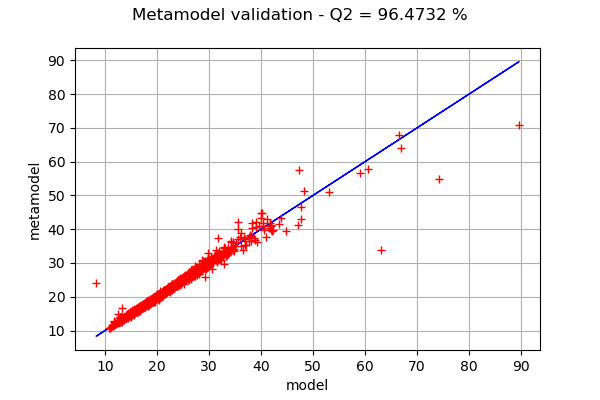

In [18]:
graph

In [19]:
np.argwhere(np.isnan(maxDeflSample))

array([], shape=(0, 2), dtype=int64)

In [20]:
q2

0.9647315578529055

**Observations :** 
- The approximation of the max deflection through the krieging metamodel is not bad at all with a q2 of 0.96
- We can still see some outliers

#### Rather then directly analysing the other output of the function, the von mises stress field, we will rather regenerate a new data set, with an entirely randomly generated input sample, rather than taking the 200 first points of LHS DOE

In [21]:
import os
import pandas as pd
os.listdir('MetaModelSamples')

['vonMises.csv',
 'sample2000_rand.csv',
 'vonMises_rand.csv',
 'maxDefl_rand.csv',
 'sample2000.csv',
 'maxDefl.csv']

In [22]:
dfVonMises = pd.read_csv('MetaModelSamples/vonMises_rand.csv',sep=';',  header=None)
dfMaxDeflection = pd.read_csv('MetaModelSamples/maxDefl_rand.csv', sep=';', header=None)
dfSample = pd.read_csv('MetaModelSamples/sample2000_rand.csv', sep=';')

In [23]:
whereNan = list(set(np.argwhere(np.isnan(dfVonMises.values))[:,0]))[0]

In [24]:
inputSample_rand = ot.Sample(dfSample.values)
inputSample_rand.setDescription(ot.Description.BuildDefault(len(dfSample.columns),'xi_'))
vonMisesSample_rand = ot.Sample(dfVonMises.values)
vonMisesSample_rand.setDescription(ot.Description.BuildDefault(len(dfVonMises.columns),'VM_'))
maxDeflSample_rand = ot.Sample(dfMaxDeflection.values)
maxDeflSample_rand.setDescription(ot.Description.BuildDefault(len(dfMaxDeflection.columns),'MDef_'))

In [25]:
inputSample_rand.erase(int(whereNan))
vonMisesSample_rand.erase(int(whereNan))
maxDeflSample_rand.erase(int(whereNan))

**Now that we have regenerated new samples and outputs, we can redo our krieging experiment:**

#### Let's define the initial values : 

In [26]:
xmin = -10 # borne inférieur de la variable d'entrée x
xmax = 10 # borne supérieure de la variable d'entrée x
n_pt = 100 # nombre des points du plan d'expériences
size_multistart = 50 # nombre de points de départ pour les options muti_start, et best_start

In [27]:
inputSample2_train = inputSample_rand[:n_pt]
outputVM2_train = vonMisesSample_rand[:n_pt]
outputMD2_train = maxDeflSample_rand[:n_pt]

inputSample2_test = inputSample_rand[n_pt:]
outputVM2_test = vonMisesSample_rand[n_pt:]
outputMD2_test = maxDeflSample_rand[n_pt:]

#### Optimisation with the option "multi_start".
##### We will do the krieging for the maximal deflection (only one dimensional output)

In [28]:
ot.RandomGenerator.SetSeed(456)

In [29]:
from collections import Sequence, Iterable

# Construction d'un modèle initiale de l'algorithme de krigeage.
algo_kriging = pt.build_default_kriging_algo(inputSample2_train, outputMD2_train, basis=None,
                            covariance_model=None, noise=None)

# Optimisation des paramètres de krigeage en paratant de l'algorithme initial.
kriging_algo = pt.estimate_kriging_theta(algo_kriging, lower_bound=None, upper_bound=None, 
                                           size=size_multistart, optim_type='multi_start')

# Récupérer les métamodèles et calculer les coefficients Q2
if isinstance(kriging_algo, (Sequence, Iterable, list)):
    print('Is list')
    kriging_result = []
    for krig_algo in kriging_algo: 
        kriging_result.append(krig_algo.getResult())
else : 
    kriging_result = kriging_algo.getResult()

if isinstance(kriging_result,(Sequence, Iterable, list)):
    print('Is list')
    kriging_meta = []
    Q2 = []
    for krig_result in kriging_result:
        kriging_meta.append(krig_result.getMetaModel())

        # calcul de Q2 pour les deux métamodèles
        Q2.append(pt.compute_Q2(input_sample, output_sample, krig_result))
else :
    kriging_meta = kriging_result.getMetaModel()
    Q2 = pt.compute_Q2(inputSample2_test, outputMD2_test, kriging_result)
print('Q2:', Q2)

<ipython-input-29-edb186eb0f7a>:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, Iterable


Q2: 0.9777533355735761


In [30]:
val = ot.MetaModelValidation(inputSample2_test, outputMD2_test, kriging_meta)

# Compute the978002 first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
graph = val.drawValidation()

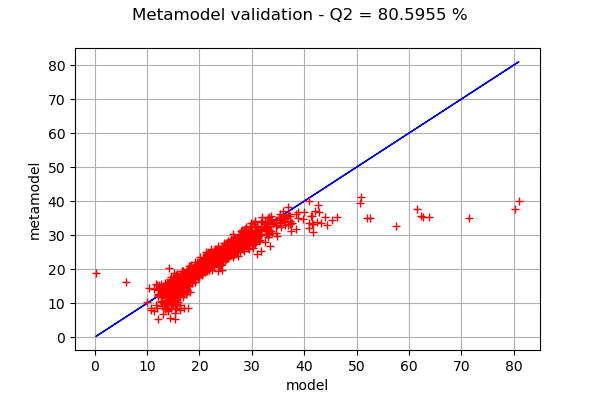

In [31]:
graph

#### Optimisation with the option "best_start".
##### Krieging for the maximal deflection (only one dimensional output)

In [32]:
ot.RandomGenerator.SetSeed(456)

In [33]:

# Construction d'un modèle initiale de l'algorithme de krigeage.
algo_kriging = pt.build_default_kriging_algo(inputSample2_train, outputMD2_train, basis=None,
                            covariance_model=None, noise=None)

# Optimisation des paramètres de krigeage en paratant de l'algorithme initial.
kriging_algo = pt.estimate_kriging_theta(algo_kriging, lower_bound=None, upper_bound=None, 
                                           size=size_multistart, optim_type='best_start')

# Récupérer les métamodèles et calculer les coefficients Q2
if isinstance(kriging_algo, (Sequence, Iterable, list)):
    print('Is list')
    kriging_result = []
    for krig_algo in kriging_algo: 
        kriging_result.append(krig_algo.getResult())
else : 
    kriging_result = kriging_algo.getResult()

if isinstance(kriging_result,(Sequence, Iterable, list)):
    print('Is list')
    kriging_meta = []
    Q2 = []
    for krig_result in kriging_result:
        kriging_meta.append(krig_result.getMetaModel())

        # calcul de Q2 pour les deux métamodèles
        Q2.append(pt.compute_Q2(input_sample, output_sample, krig_result))
else :
    kriging_meta = kriging_result.getMetaModel()
    Q2 = pt.compute_Q2(inputSample2_test, outputMD2_test, kriging_result)
print('Q2:', Q2)

Q2: 0.9780043178701491


In [34]:
val = ot.MetaModelValidation(inputSample2_test, outputMD2_test, kriging_meta)

# Compute the first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
graph = val.drawValidation()

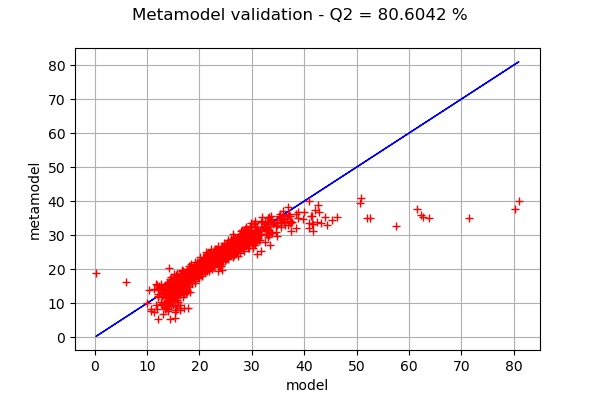

In [35]:
graph

**We see that already with multi_start and the 100 points the krieging results are excellent. Changing the optimisation type has not as much of an inluence.**
Let's redo the krieging with less points : 

In [36]:
xmin = -10 # borne inférieur de la variable d'entrée x
xmax = 10 # borne supérieure de la variable d'entrée x
n_pt = 25 # nombre des points du plan d'expériences
size_multistart = 10# nombre de points de départ pour les options muti_start, et best_start

In [37]:
inputSample2_train = inputSample_rand[:n_pt]
outputVM2_train = vonMisesSample_rand[:n_pt]
outputMD2_train = maxDeflSample_rand[:n_pt]

inputSample2_test = inputSample_rand[n_pt:]
outputVM2_test = vonMisesSample_rand[n_pt:]
outputMD2_test = maxDeflSample_rand[n_pt:]

#### Optimisation with the option "multi_start".
##### We will do the krieging for the maximal deflection (only one dimensional output)

In [38]:
ot.RandomGenerator.SetSeed(456)

In [39]:
from collections import Sequence, Iterable

# Construction d'un modèle initiale de l'algorithme de krigeage.
algo_kriging = pt.build_default_kriging_algo(inputSample2_train, outputMD2_train, basis=None,
                            covariance_model=None, noise=None)

# Optimisation des paramètres de krigeage en paratant de l'algorithme initial.
kriging_algo = pt.estimate_kriging_theta(algo_kriging, lower_bound=None, upper_bound=None, 
                                           size=size_multistart, optim_type='multi_start')

# Récupérer les métamodèles et calculer les coefficients Q2
if isinstance(kriging_algo, (Sequence, Iterable, list)):
    print('Is list')
    kriging_result = []
    for krig_algo in kriging_algo: 
        kriging_result.append(krig_algo.getResult())
else : 
    kriging_result = kriging_algo.getResult()

if isinstance(kriging_result,(Sequence, Iterable, list)):
    print('Is list')
    kriging_meta = []
    Q2 = []
    for krig_result in kriging_result:
        kriging_meta.append(krig_result.getMetaModel())

        # calcul de Q2 pour les deux métamodèles
        Q2.append(pt.compute_Q2(input_sample, output_sample, krig_result))
else :
    kriging_meta = kriging_result.getMetaModel()
    Q2 = pt.compute_Q2(inputSample2_test, outputMD2_test, kriging_result)
print('Q2:', Q2)

Q2: -5.440557875280305e-05


In [40]:
val = ot.MetaModelValidation(inputSample2_test, outputMD2_test, kriging_meta)

# Compute the first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
graph = val.drawValidation()

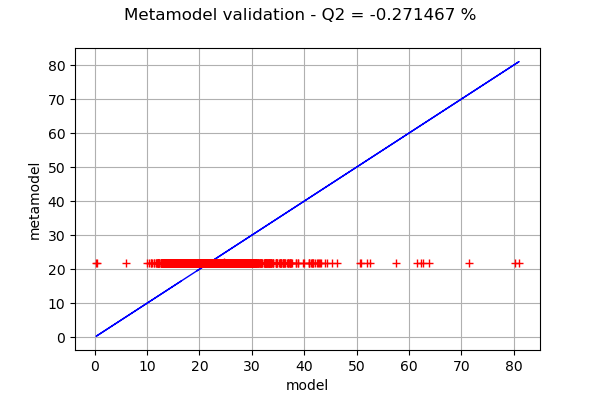

In [41]:
graph

#### Optimisation with the option "best_start".
##### Krieging for the maximal deflection (only one dimensional output)

In [42]:
ot.RandomGenerator.SetSeed(456)

In [ ]:

# Construction d'un modèle initiale de l'algorithme de krigeage.
algo_kriging = pt.build_default_kriging_algo(inputSample2_train, outputMD2_train, basis=None,
                            covariance_model=None, noise=None)

# Optimisation des paramètres de krigeage en paratant de l'algorithme initial.
kriging_algo = pt.estimate_kriging_theta(algo_kriging, lower_bound=None, upper_bound=None, 
                                           size=size_multistart, optim_type='best_start')

# Récupérer les métamodèles et calculer les coefficients Q2
if isinstance(kriging_algo, (Sequence, Iterable, list)):
    print('Is list')
    kriging_result = []
    for krig_algo in kriging_algo: 
        kriging_result.append(krig_algo.getResult())
else : 
    kriging_result = kriging_algo.getResult()

if isinstance(kriging_result,(Sequence, Iterable, list)):
    print('Is list')
    kriging_meta = []
    Q2 = []
    for krig_result in kriging_result:
        kriging_meta.append(krig_result.getMetaModel())

        # calcul de Q2 pour les deux métamodèles
        Q2.append(pt.compute_Q2(input_sample, output_sample, krig_result))
else :
    kriging_meta = kriging_result.getMetaModel()
    Q2 = pt.compute_Q2(inputSample2_test, outputMD2_test, kriging_result)
print('Q2:', Q2)

In [ ]:
val = ot.MetaModelValidation(inputSample2_test, outputMD2_test, kriging_meta)

# Compute the first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
graph = val.drawValidation()

In [ ]:
graph

# Now that we have analyzed a bit the single output function (maximum deflection), we can now begin to create the metamodel of the multidimensional output, the Von Mises Stress Field. 
### We will do somethin similar to before, wuth first 200 points, than 100 and than 25 and we will use the two start methods. 

In [ ]:
xmin = -10 # borne inférieur de la variable d'entrée x
xmax = 10 # borne supérieure de la variable d'entrée x
n_pt = 50 # nombre des points du plan d'expériences
size_multistart = 3 # nombre de points de départ pour les options muti_start, et best_start

In [ ]:
inputSample2_train = inputSample_rand[:n_pt]
outputVM2_train = vonMisesSample_rand[:n_pt]
outputMD2_train = maxDeflSample_rand[:n_pt]

inputSample2_test = inputSample_rand[n_pt:]
outputVM2_test = vonMisesSample_rand[n_pt:]
outputMD2_test = maxDeflSample_rand[n_pt:]

#### Optimisation with the option "multi_start".
##### We will do the krieging for the maximal deflection (only one dimensional output)

In [ ]:
ot.RandomGenerator.SetSeed(456)

In [ ]:
from collections import Sequence, Iterable

# Construction d'un modèle initiale de l'algorithme de krigeage.
algo_kriging = pt.build_default_kriging_algo(inputSample2_train, outputVM2_train, basis=None,
                            covariance_model=None, noise=None)

# Optimisation des paramètres de krigeage en paratant de l'algorithme initial.
kriging_algo = pt.estimate_kriging_theta(algDeflectiono_kriging, lower_bound=None, upper_bound=None, 
                                           size=size_multistart, optim_type='best_start')

# Récupérer les métamodèles et calculer les coefficients Q2
if isinstance(kriging_algo, (Sequence, Iterable, list)):
    print('Is list')
    kriging_result = []
    for krig_algo in kriging_algo: 
        kriging_result.append(krig_algo.getResult())
else : 
    kriging_result = kriging_algo.getResult()

if isinstance(kriging_result,(Sequence, Iterable, list)):
    print('Is list')
    kriging_meta = []
    Q2 = []
    for krig_result in kriging_result:
        kriging_meta.append(krig_result.getMetaModel())

        # calcul de Q2 pour les deux métamodèles
        Q2.append(pt.compute_Q2(inputSample2_test, outputVM2_test, krig_result))
else :
    kriging_meta = kriging_result.getMetaModel()
    Q2 = pt.compute_Q2(inputSample2_test, outputVM2_test, kriging_result)
print('Q2:', Q2)

In [ ]:
r2s = []
residuals = []
for i, metamod in enumerate(kriging_meta) : 
    val = ot.MetaModelValidation(inputSample2_test, outputVM2_test[:,i], metamod)

    # Compute the first indicator : r2
    r2 = val.computePredictivityFactor()
    # Get the residual
    residual = val.getResidualSample()
    # Get the histogram of residual
    histoResidual = val.getResidualDistribution(False)
    r2s.append(r2)
    residuals.append(residual)
    # Draw the validation graph
    graph = val.drawValidation()
    ot.Show(graph)

In [ ]:
r2s

In [ ]:
residuals